# System Identification

System identification is the process of finding a transfer function that predicts outputs
that are close to those predicted by experimental data. These data
may be obtained from actual experiments for from a detailed nonlinear model.
System identification involves: iteratively choosing the size of the numerator and denominator polynomial
of the transfer function,
estimating the parameters of the transfer function, and evaluating the quality of the fit to
the predictions of the transfer function.

## Preliminaries

In [ ]:
!pip install controlSBML
!pip install control

In [29]:
import controlSBML as ctl

import matplotlib.pyplot as plt
import control
import numpy as np
import pandas as pd
import tellurium as te
ctl.__version__

'1.1.03'

In [30]:
s = control.TransferFunction.s

## Models

### LINEAR_MODEL

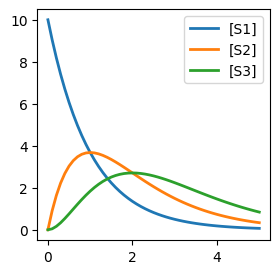

In [12]:
LINEAR_MODEL = """
model *model_main()
J1: S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 10; S2 = 0; S3 = 0

k1 = 1
k2 = 1
k3 = 1
end
"""
rr = te.loada(LINEAR_MODEL)
rr.simulate()
rr.plot(figsize=(3,3))

In [13]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MODEL, input_names=["S1"], output_names=["S3"])

### WOLF_MODEL

In [4]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"
rr = te.loadSBMLModel(WOLF_URL)
WOLF_MODEL = rr.getAntimony()
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_names=["at_"], output_names=["s5"])
print(WOLF_MODEL)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

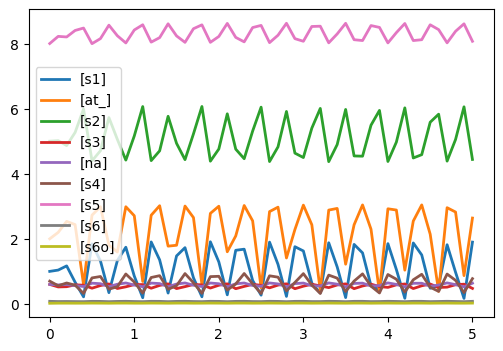

In [5]:
rr = te.loada(WOLF_MODEL)
rr.simulate()
rr.plot()

### MTOR_MODEL

In [6]:
MTOR_URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
rr = te.loadSBMLModel(MTOR_URL)
MTOR_MODEL = rr.getAntimony()
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_names=["DEPTOR"], output_names=["mTORC1"])
print(MTOR_MODEL)

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

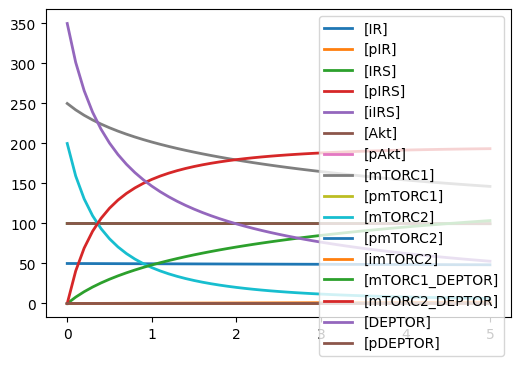

In [7]:
rr = te.loada(MTOR_MODEL)
rr.simulate()
rr.plot()

# Linear model transfer function

In this section, we use LINEAR_MODEL to illustrate system identification.
The work can be simplied by making use of the ``SISOTransferFunctionBuilder``
object in ``ControlSBML``.

## Step 1. Determine the operating region

The operating region is the range of control inputs that should handled by the controller.
We want to see how responsive the system is to the possible outputs from the controller.
We assess the operating region by using a *staircase input*.
This is a sequence of steps of the same height that have a duration that is sufficiently
long so that the system stabilizes.

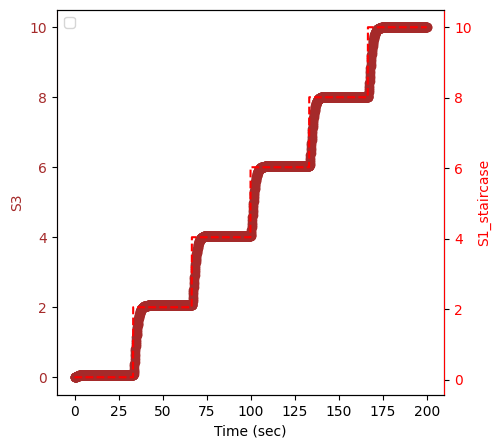

In [16]:
STAIRCASE = LINEAR_CTLSB.plotStaircaseResponse(times=np.linspace(0, 200, 2000))

## Step 2. Find the transfer function

To fit a transfer function, we must specify the number of terms in the
numerator and denominator polynomials for the transfer function.

In [20]:
?LINEAR_CTLSB.plotTransferFunctionFit

Signature:
LINEAR_CTLSB.plotTransferFunctionFit(
    num_numerator: int = 1,
    num_denominator: int = 3,
    fit_start_time: Optional[float] = None,
    fit_end_time: Optional[float] = None,
    **kwargs,
)
Docstring:
Simulates the staircase response and plots it. Sets the fitter result.

Args:
    num_numerator: int (number of numerator terms)
    num_denominator: int (number of denominator terms)
    fit_start_time: float (time at which fitting starts)
    fit_end_time: float (time at which fitting ends)
    kwargs: (plot options)

Returns:
    Timeseries (predicted, staircase)
    AntimonyBuilder
File:      ~/home/Technical/repos/controlSBML/src/controlSBML/control_sbml.py
Type:      method


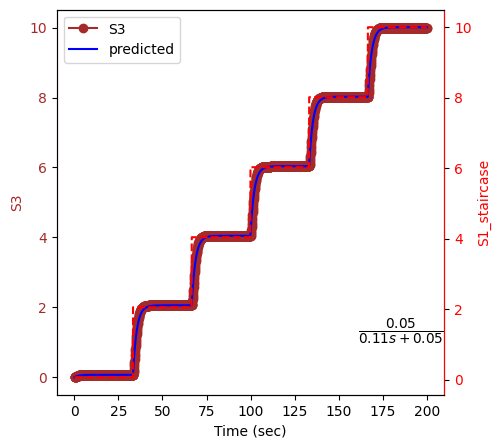

TransferFunction(array([0.]), array([1.]))

In [25]:
result = LINEAR_CTLSB.plotTransferFunctionFit(num_numerator=1, num_denominator=2, times=np.linspace(0, 200, 2000))

In [31]:
LINEAR_TF = 0.05/(.11*s + 0.05)

In [32]:
LINEAR_TF.poles()

array([-0.45454545+0.j])

In [33]:
LINEAR_TF.dcgain()

1.0

#  Wolf Transfer Function

In [47]:
WOLF_CTLSB = ctl.ControlSBML(WOLF_MODEL, input_names=["s1"], output_names=["s5"])

## Determine the operating region

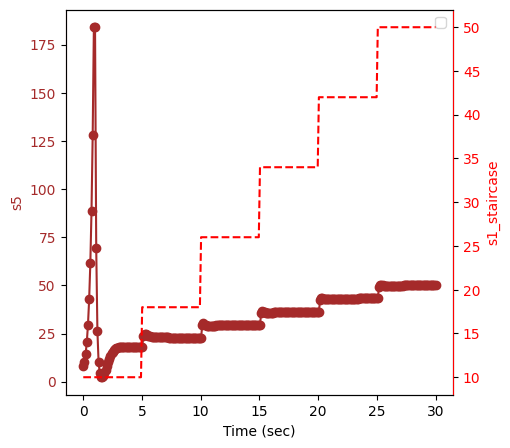

In [51]:
_ = WOLF_CTLSB.plotStaircaseResponse(times=np.linspace(0, 30, 300), initial_value=10, final_value=50)

## Find the transfer function

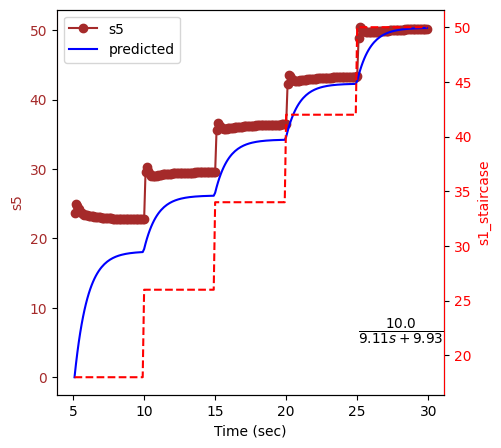

In [52]:
_ = WOLF_CTLSB.plotTransferFunctionFit(times=np.linspace(0, 30, 300), initial_value=10, final_value=50,
                                      fit_start_time=5)

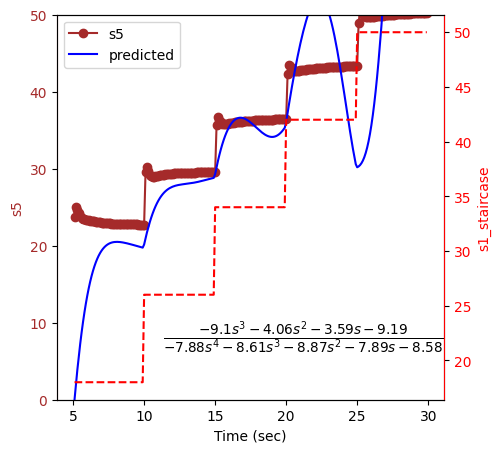

In [55]:
_ = WOLF_CTLSB.plotTransferFunctionFit(num_numerator=4, num_denominator=5, times=np.linspace(0, 30, 300),
                                       fit_start_time=5, initial_value=10, final_value=50, ylim=[0, 50])

In [57]:
WOLF_TF = (-9.1*s**3 - 4.06*s**2 -3.59*s - 9.19)/(-7.88*s**4 - 8.61*s**3 - 8.87*s**2 - 7.89*s - 8.58)
WOLF_TF.poles()

array([-0.83519545+0.64069178j, -0.83519545-0.64069178j,
        0.28887565+0.94827132j,  0.28887565-0.94827132j])

# mTOR transfer function

In [ ]:
MTOR_CTLSB = ctl.ControlSBML(MTOR_MODEL, input_names=["V1"], output_names=["pmTORC1", "pmTORC2"])